| Syntax | Description |
| ----------- | ----------- |
| Header | Title |
| Paragraph | Text |

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [33]:
def f1(x1,y1):
    return (x1**2+y1-11)**2+(x1+y1**2-7)**2
def f2(x2,y2):
    return 2*x2**2+1.05*x2**4+(x2**6)/6+x2*y2+y2**2

def sumF1F2(individual):
    x1,y1,x2,y2 = individual
    return f1(x1,y1)+f2(x2,y2)

In [34]:
def getPlotVariables(minVariable, maxVariable, function):
    x = np.linspace(minVariable, maxVariable, 100)
    y = x.copy()
    X, Y = np.meshgrid(x, y)
    Z = function(X, Y)
    return X, Y, Z

In [35]:
def draw2DPlot(X,Y,Z,bestPoint=None, additionalPoints=None):

    plt.contourf(X,Y,Z, levels=20, colors='white')
    contour = plt.contour(X,Y,Z, levels=10, colors='black')
    plt.clabel(contour, inline=1, fontsize=8)

    if bestPoint is not None:
        plt.plot(bestPoint[0], bestPoint[1], 'ro')
    if additionalPoints is not None:
        plt.scatter(additionalPoints[:,0], additionalPoints[:,1],marker='.',s=30)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

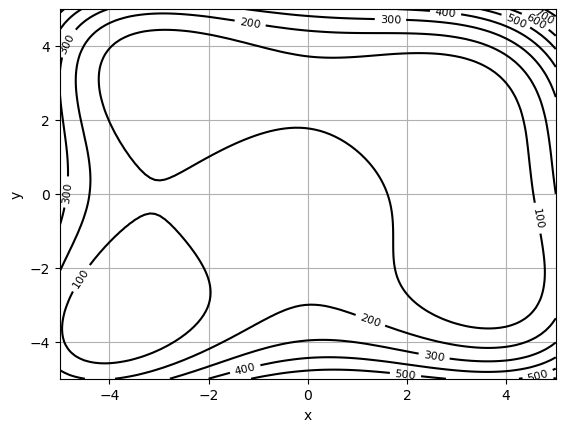

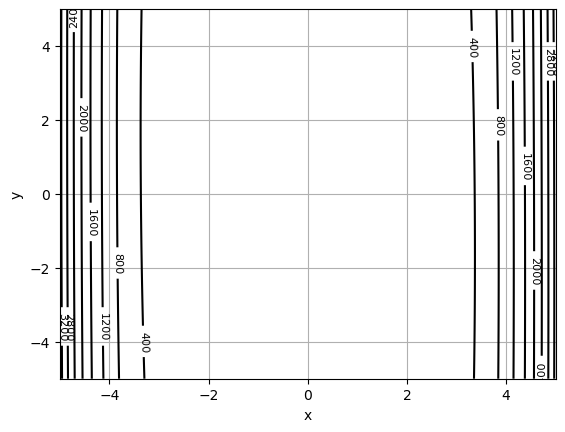

In [36]:
X1,Y1,Z1 = getPlotVariables(-5,5,f1)
draw2DPlot(X1,Y1,Z1)


X2,Y2,Z2 = getPlotVariables(-5,5,f2)
draw2DPlot(X2,Y2,Z2)

In [37]:
def gaussMutation(individual, sigma):
    mutatedIndividual = np.zeros(len(individual))
    for i in range(len(individual)):
        mutatedIndividual[i] = individual[i] + np.random.normal(0, sigma)
    return mutatedIndividual


In [38]:
def mutatePopulation(population, sigma):
    mutatedPopulation = []
    for individual in population:
        individual1 = gaussMutation(individual, sigma)
        mutatedPopulation.append(individual1)
    return mutatedPopulation

In [39]:
def individualSinglePointCrossBreeding(individual1, individual2):
    point = random.randint(0, len(individual1)-1)
    return np.concatenate((individual1[:point], individual2[point:]), axis=None)

In [40]:
def populationCrossBreeding(population, crossingProbability):
    random.shuffle(population)
    crossedPopulation = []
    for i in range(0, len(population), 2):
        if random.random() < crossingProbability:
            crossedPopulation.append(individualSinglePointCrossBreeding(population[i], population[i+1]))
            crossedPopulation.append(individualSinglePointCrossBreeding(population[i+1], population[i]))
        else:
            crossedPopulation.append(population[i])
            crossedPopulation.append(population[i+1])
    return crossedPopulation

In [41]:
def generateRandomPopulation(size, D):
    return [np.random.uniform(D[0], D[1], 4) for _ in range(size)]


In [42]:
def isOutOfRange(individual, D):
    return individual[0] <= D[0] or individual[0] >= D[1] or individual[1] <= D[0] or individual[1] >= D[1] or individual[2] <= D[0] or individual[2] >= D[1] or individual[3] <= D[0] or individual[3] >= D[1]

In [43]:
def gradeIndividual(individual, D, gradingFunction):
    return gradingFunction(individual)

In [44]:
def gradePopulation(population,D,gradingFunction):
    sum = 0
    for individual in population:
        sum += gradeIndividual(individual,D,gradingFunction)
    return sum

In [45]:
def tournamentSelection(population,D, gradingFunction):
    populationAfterSelection = []

    for _ in range(len(population)):
        individual1 = random.choice(population)
        individual2 = random.choice(population)
        if gradeIndividual(individual1,D,gradingFunction) < gradeIndividual(individual2,D,gradingFunction):
            populationAfterSelection.append(individual1)
        else:
            populationAfterSelection.append(individual2)
    return populationAfterSelection


In [46]:
def bringIndividualToBoundres(individual, D):
    for i in range(len(individual)):
        individual[i] = max(D[0], min(D[1], individual[i]))
    return individual

In [47]:
def bringPopulationToBoundries(population, D):
    for individual in population:
        individual = bringIndividualToBoundres(individual,D)
    return population

In [48]:
def updateBestIndividual(population, lastBestIndividual,D,gradingFunction):
    bestIndividual = lastBestIndividual
    bestValue = gradeIndividual(lastBestIndividual,D,gradingFunction)
    for individual in population:
        if gradeIndividual(individual,D,gradingFunction) < bestValue:
            bestIndividual = individual
            bestValue = gradeIndividual(individual,D,gradingFunction)
    return bestIndividual


In [49]:
def findBestIndividual(population,D,gradingFunction):
    best = population[0]
    for individual in population:
        if gradeIndividual(individual,D,gradingFunction) < gradeIndividual(best,D,gradingFunction):
            best = individual
    return best

In [50]:
def generateValuesAroundPoint(size, point,sigma):
    return np.random.normal(point, sigma, (size, 2))

In [51]:
def generateSpecificF1Population(size, point, sigma, D):
    population = generateValuesAroundPoint(size, point, sigma)
    x2 = np.random.uniform(D[0], D[1], size)
    y2 = np.random.uniform(D[0], D[1], size)
    population = np.concatenate((population, np.array([x2,y2]).T), axis=1)
    population= bringPopulationToBoundries(population, D)
    return population

In [52]:
def evolutionAlgorithm(maxIterations,populationSize,crossingProbability,sigma,D,startingPopulation=None,gradingFunction=sumF1F2):
    generations = []
    if startingPopulation is None:
        lastPopulation = generateRandomPopulation(populationSize, D)
    else:
        lastPopulation = bringPopulationToBoundries(startingPopulation,D)
    bestIndividual = updateBestIndividual(lastPopulation, lastPopulation[0],D,gradingFunction)
    lastPopulationGrade = gradePopulation(lastPopulation,D,gradingFunction)
    i = 0
    generations.append(lastPopulation)
    while i < maxIterations:
        newPopulation = tournamentSelection(lastPopulation,D,gradingFunction)
        newPopulation = populationCrossBreeding(newPopulation, crossingProbability)
        newPopulation = mutatePopulation(newPopulation, sigma)
        newPopulation = bringPopulationToBoundries(newPopulation,D)
        bestIndividual = updateBestIndividual(newPopulation, bestIndividual, D,gradingFunction)
        newPopulationGrade = gradePopulation(newPopulation,D,gradingFunction)
        if newPopulationGrade < lastPopulationGrade:
            lastPopulation = newPopulation
            lastPopulationGrade = newPopulationGrade
        generations.append(lastPopulation)
        i += 1
    return generations, bestIndividual

In [53]:
def printPlots(numberOfGenerations,D,size,step,crossingProbability,sigma,gradingFunction=sumF1F2,startingPopulation=None):
    generations, bestIndividual = evolutionAlgorithm(numberOfGenerations, size, crossingProbability,sigma, D,startingPopulation,gradingFunction)
    X1,Y1,Z1 = getPlotVariables(-5,5,f1)
    X2,Y2,Z2 = getPlotVariables(-5,5,f2)

    for i in range(0,numberOfGenerations+1,step):
        additionalPoints = generations[i]
        additionalPointsF1 = np.array([[item[0], item[1]] for item in additionalPoints])
        additionalPointsF2 = np.array([[item[2], item[3]] for item in additionalPoints])
        currentBestIndividual = findBestIndividual(additionalPoints,D,gradingFunction)

        print(f'Epoch: {i} Best individual: {currentBestIndividual}, F(bestIndividual)={sumF1F2(currentBestIndividual)}')



        draw2DPlot(X1,Y1,Z1,currentBestIndividual[0:2],additionalPointsF1[1:-1])
        draw2DPlot(X2,Y2,Z2,currentBestIndividual[2:4],additionalPointsF2[1:-1])

    print(f'All time Best individual: {bestIndividual}, F(bestIndividual)={sumF1F2(bestIndividual)}')
    draw2DPlot(X1,Y1,Z1,bestIndividual[0:2])

    draw2DPlot(X2,Y2,Z2,bestIndividual[2:4])
    # Wektor wyników w danej generacji
    wyniki_danej_generacji = [gradePopulation(item,D,gradingFunction) for item in generations]

    plt.plot(wyniki_danej_generacji)
    plt.xlabel('Generation')
    plt.ylabel('Score')
    plt.title('Generations scores')
    plt.show()

Losowa dystrybucja punktów po całym obszarze

Epoch: 0 Best individual: [ 3.04354764  1.96274995 -0.57030239 -2.49217937], F(bestIndividual)=8.461426031296936


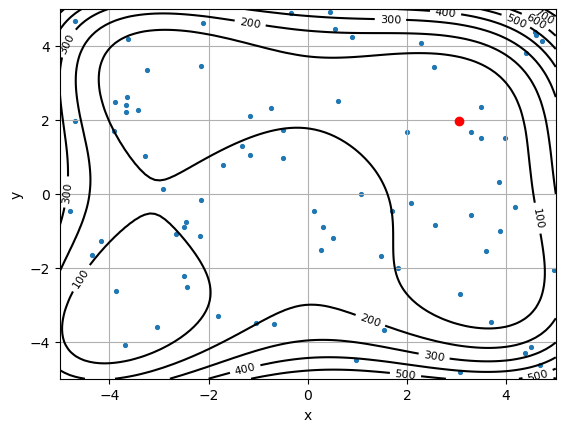

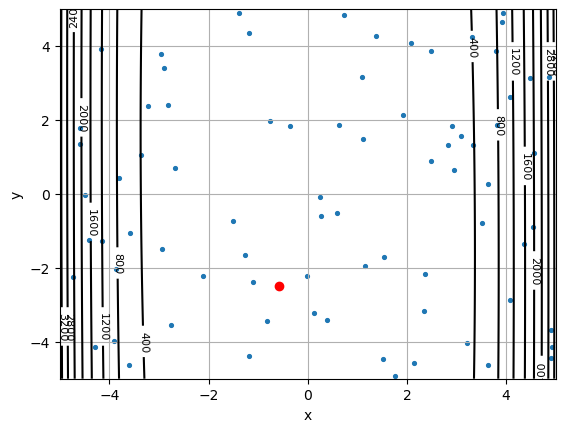

Epoch: 6 Best individual: [ 3.66685549 -1.95879357  0.43127326 -1.12946726], F(bestIndividual)=1.6889227511339084


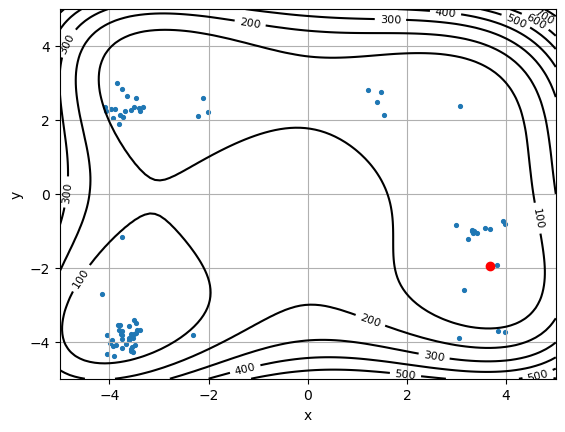

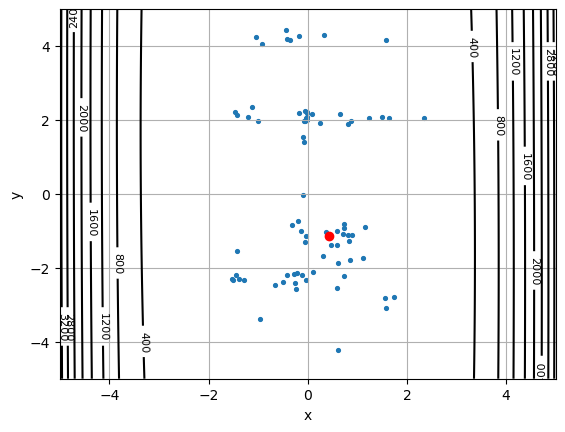

Epoch: 12 Best individual: [ 3.66528069 -1.74667618 -0.0520806  -0.99450549], F(bestIndividual)=1.5996367227123023


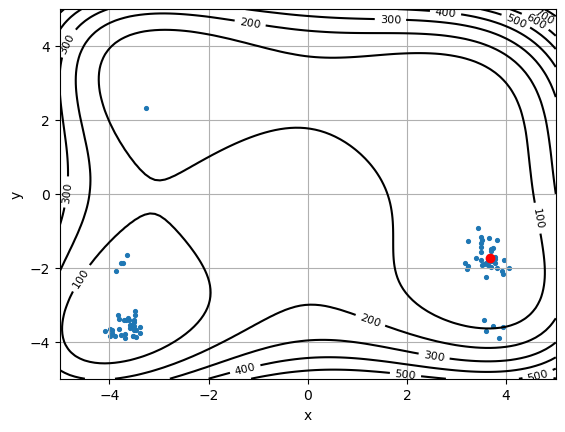

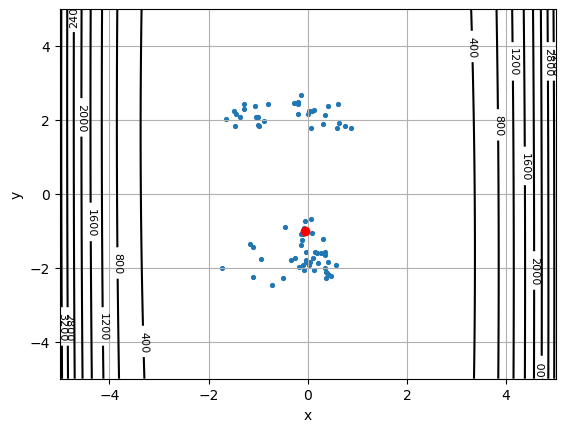

Epoch: 18 Best individual: [ 3.63554987 -1.8135457   0.14157824 -1.11214921], F(bestIndividual)=1.2885875762593033


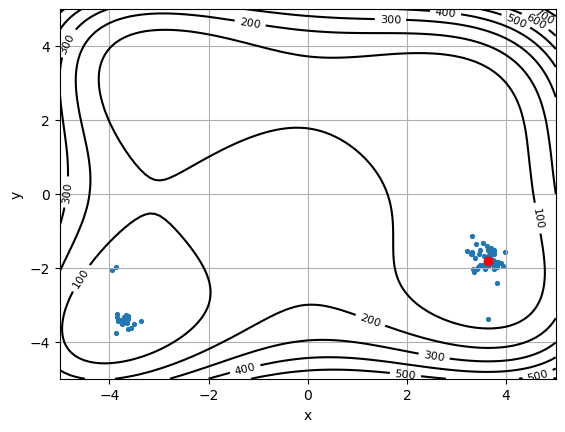

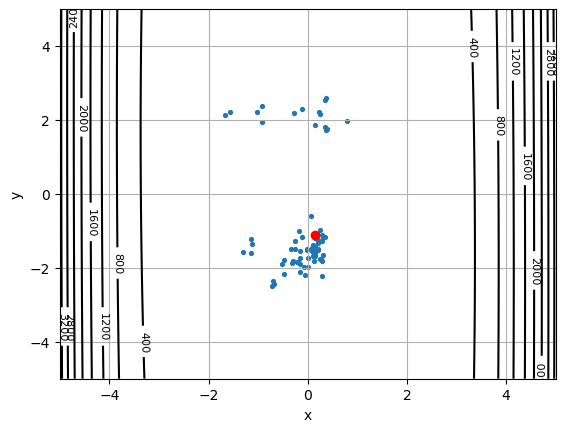

Epoch: 24 Best individual: [ 3.57384797 -1.93513158  0.37124892 -0.93237142], F(bestIndividual)=0.9471878480027621


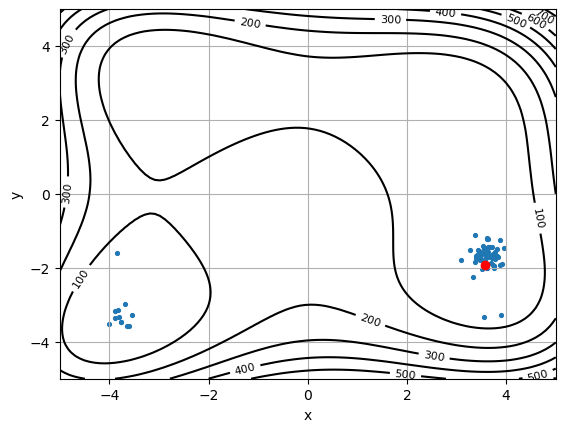

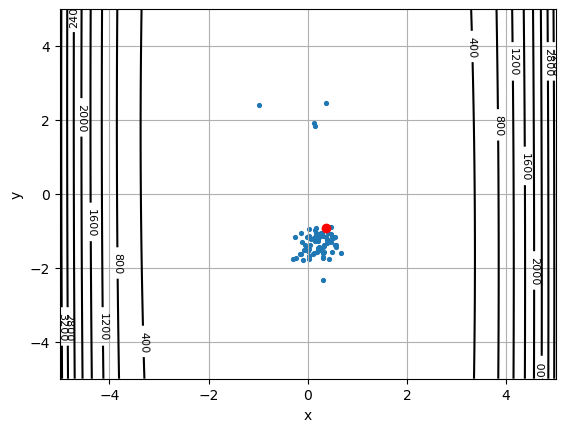

Epoch: 30 Best individual: [ 3.5770441  -1.87333554  0.36985876 -0.76977619], F(bestIndividual)=0.615081608713469


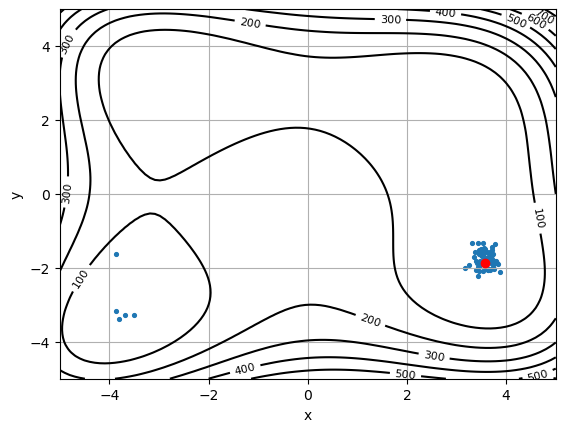

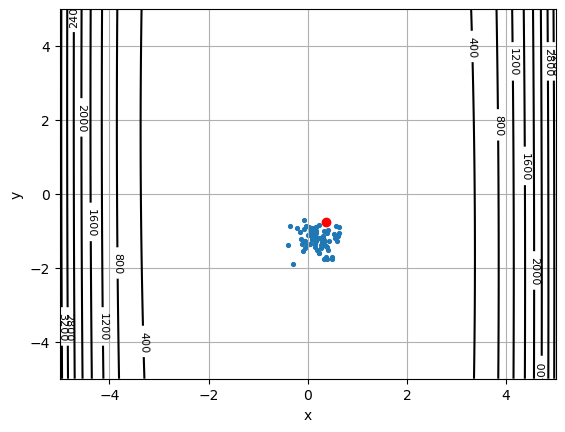

All time Best individual: [ 3.5770441  -1.87333554  0.36985876 -0.76977619], F(bestIndividual)=0.615081608713469


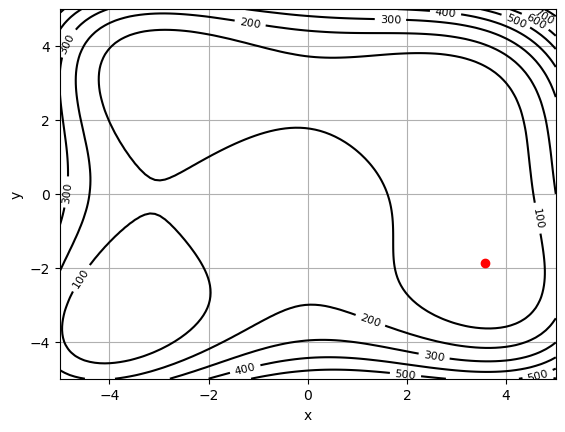

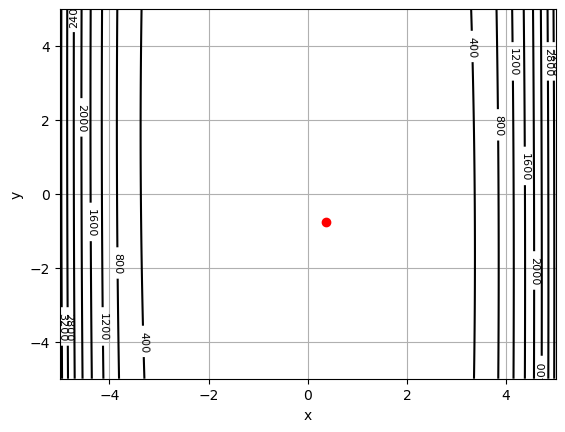

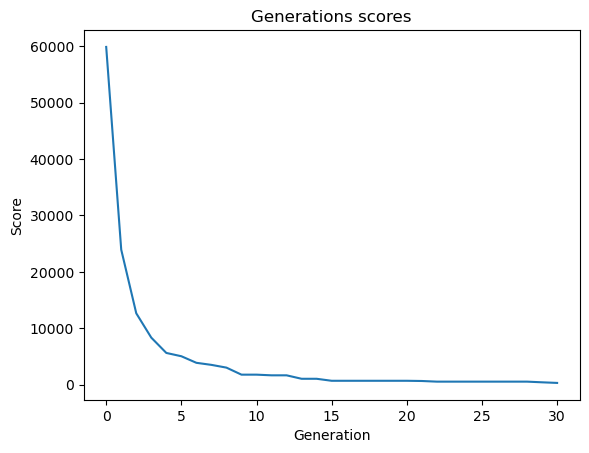

In [63]:
D=[-5,5]
size=80
step=6
crossingProbability=0.95
sigma=0.1
generations=30
printPlots(generations,D,size,step,crossingProbability,sigma)

Rozkład normalny wokół x1,y1 = (-0.3, -0.9), reszta losowo

Epoch: 0 Best individual: [-1.23127404  2.13436721  0.95448136  3.36706671], F(bestIndividual)=84.89823676654224


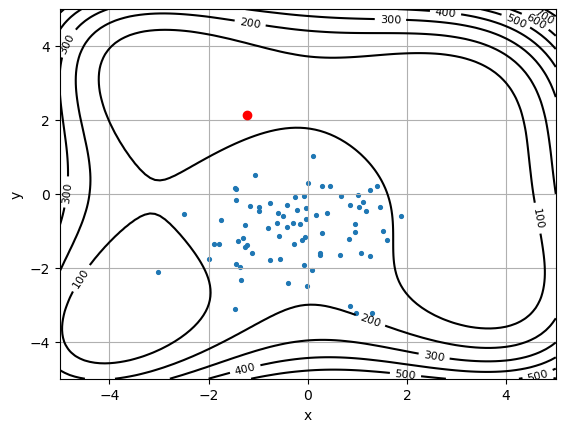

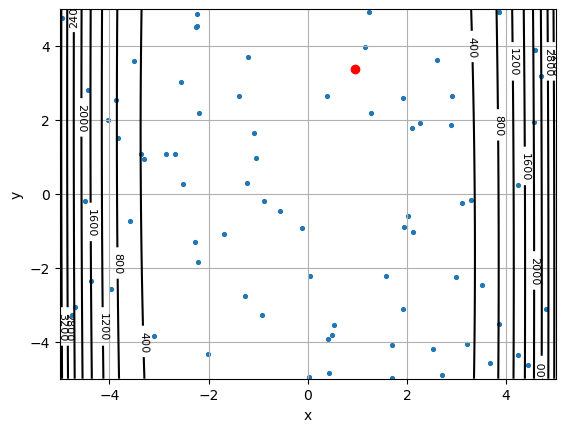

Epoch: 10 Best individual: [-2.80775495  2.98944784  1.24402958 -2.41546141], F(bestIndividual)=9.832107219149279


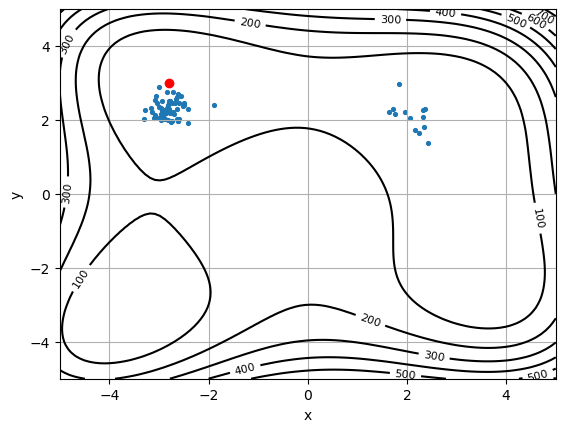

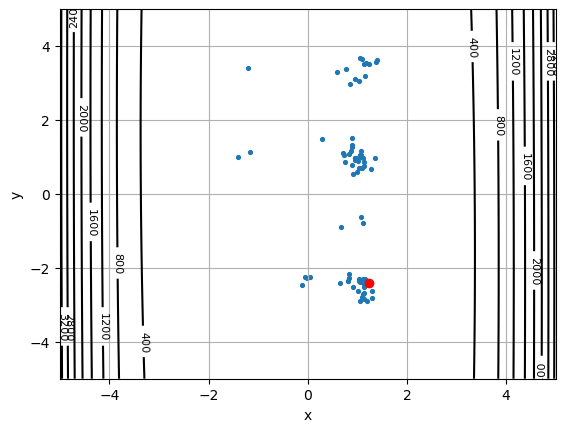

Epoch: 20 Best individual: [-2.72260699  3.05581485  0.0824134  -0.57057463], F(bestIndividual)=0.7226786571533519


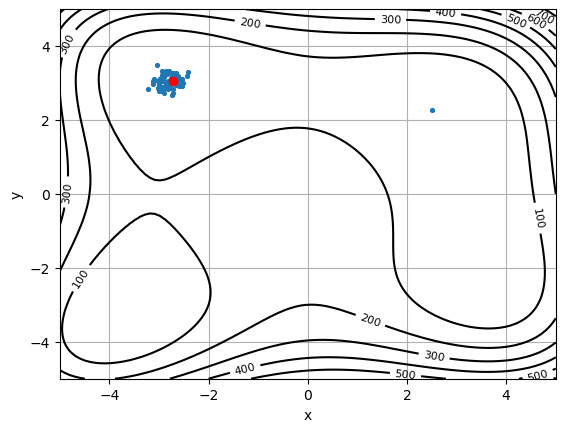

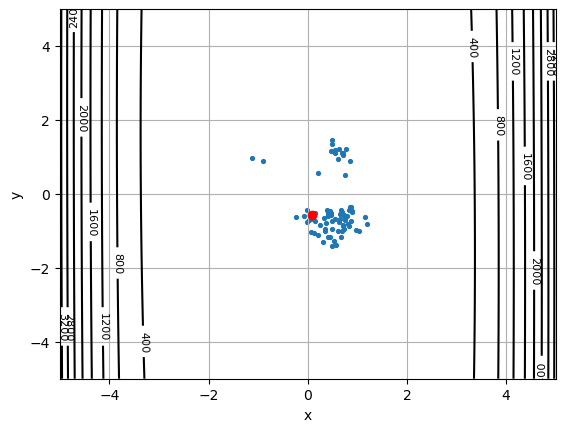

Epoch: 30 Best individual: [-2.76948886  3.12243555  0.31796139 -0.40883318], F(bestIndividual)=0.2937046344500115


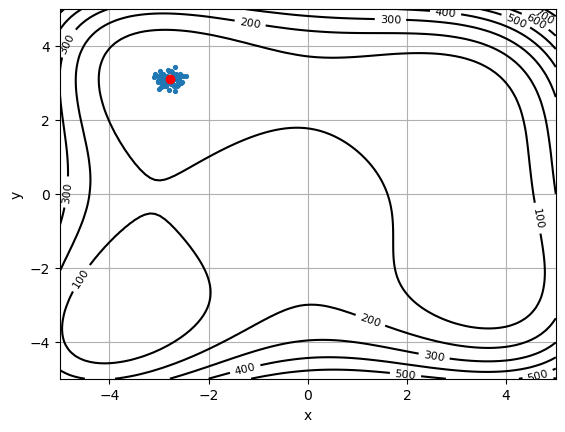

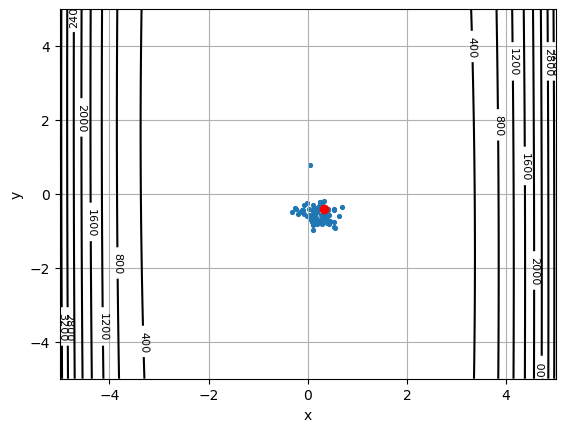

All time Best individual: [-2.78671525  3.10886506  0.20506558 -0.29695491], F(bestIndividual)=0.1437777230081469


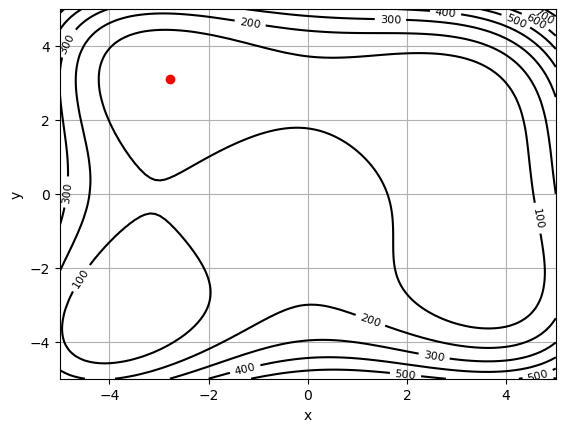

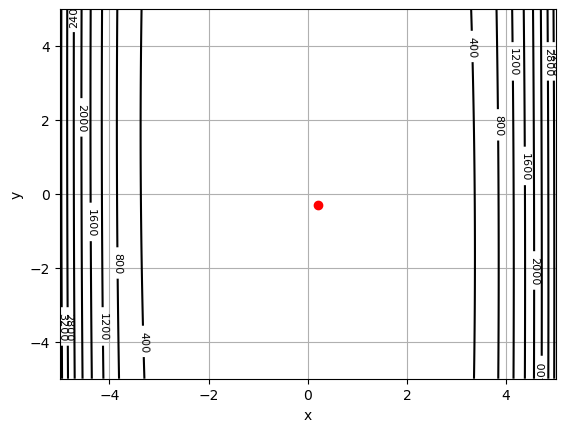

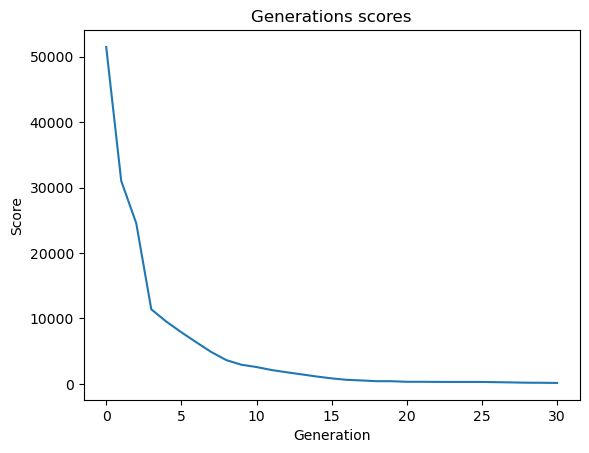

In [55]:
D=[-5,5]
size=80
step=5
crossingProbability=0.95
sigma=0.1
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
printPlots(numberOfGenerations,D,size,step,crossingProbability,sigma,sumF1F2,startingPopulation)

In [56]:
def alreadyFound(x,y,foundItems):
    for item in foundItems:
        if np.absolute(item[0][0] - x) < 0.2  and np.absolute(item[0][1] - y) < 0.2:
            return True
    return False

In [57]:
def algorithmStatistics(numberOfGenerations, populationSize, crossingProbability, sigma, D, runs,startingPopulation=None, gradingFunction=sumF1F2):
    foundItems = []
    sumValue = 0
    values = []
    for _ in range(runs):

        generations, bestIndividual = evolutionAlgorithm(numberOfGenerations, populationSize, crossingProbability, sigma, D,startingPopulation, gradingFunction)
        sumValue += gradingFunction(bestIndividual)
        values.append(gradingFunction(bestIndividual))
        if not alreadyFound(bestIndividual[0], bestIndividual[1], foundItems):
            foundItems.append([[round(bestIndividual[0],1), round(bestIndividual[1],1)], 1])
        else:
            for item in foundItems:
                if np.absolute(item[0][0] - bestIndividual[0]) < 0.2  and np.absolute(item[0][1] -  bestIndividual[1]) < 0.2:
                # if item[0][0] == round(bestIndividual[0],1) and item[0][1] == round(bestIndividual[1],1):
                    item[1] += 1
    standardDeviation = np.std(values)
    return foundItems, sumValue/runs, standardDeviation

In [58]:
def printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation=None,gradingFunction=sumF1F2):
    results,average,standardDeviation = algorithmStatistics(numberOfGenerations,size,crossingProbability,sigma,D,100,startingPopulation,gradingFunction)

    points = []
    count = []

    for item in results:
        points.append(item[0].__str__())
        count.append(item[1])
    plt.bar(range(len(points)),count, width=0.5,tick_label=points, align='center')

    plt.xlabel('Minimums')
    plt.ylabel('Number of occurences')
    plt.title('Number of occurences of minimums in 100 runs')


    plt.show()
    print(f'Average value: {average}')
    print(f'Standard deviation value: {standardDeviation}')

size: 80 crossingProbability: 0.8 sigma: 0.1 numberOfGenerations: 30 
Starting population generation type: All Random


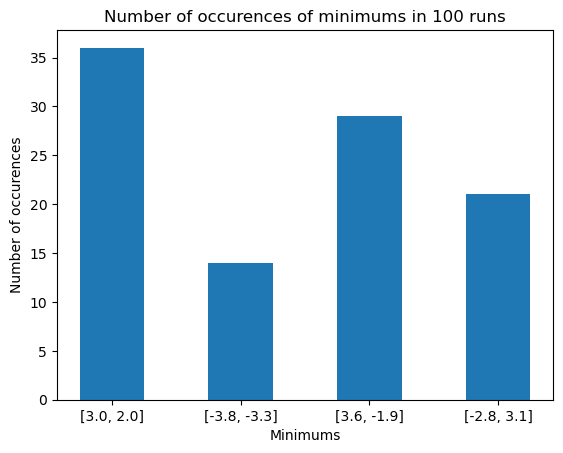

Average value: 0.08509109761986636
Standard deviation value: 0.1567053465787504
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.1 numberOfGenerations: 30 
Starting population generation type: All Random


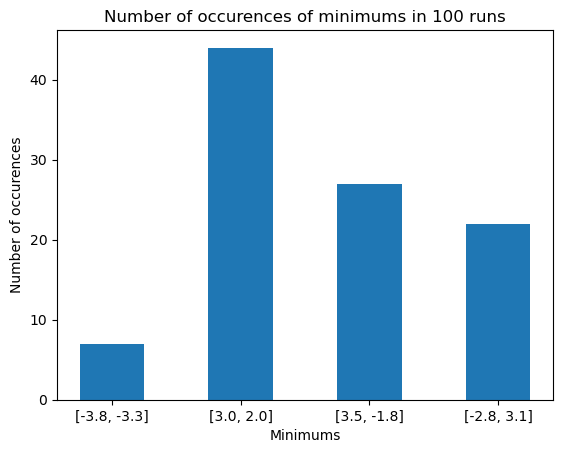

Average value: 0.08208201465505045
Standard deviation value: 0.10301217591767436
##############################################################################################################################################################################
size: 80 crossingProbability: 0.87 sigma: 0.1 numberOfGenerations: 30 
Starting population generation type: All Random


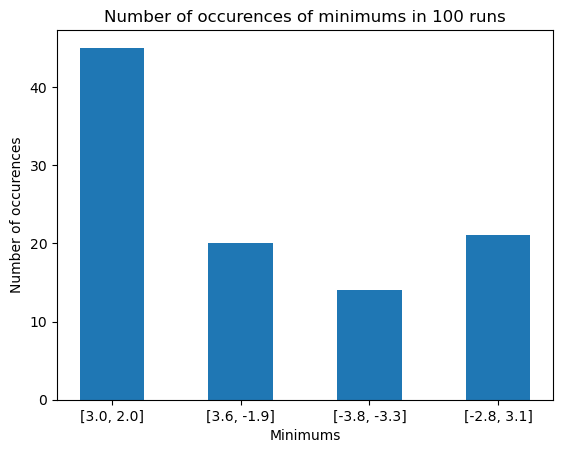

Average value: 0.07870743094501695
Standard deviation value: 0.11587278044016451
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.3 numberOfGenerations: 30 
Starting population generation type: All Random


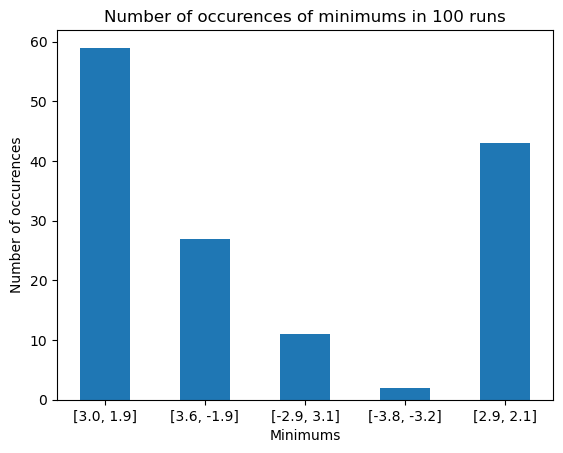

Average value: 0.18492310068048343
Standard deviation value: 0.11572296675587528
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.05 numberOfGenerations: 30 
Starting population generation type: All Random


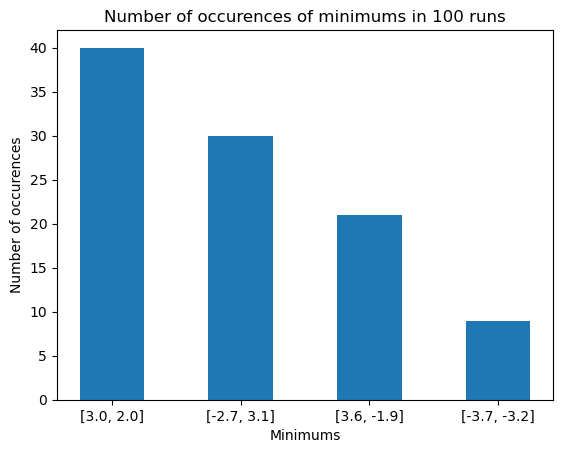

Average value: 0.13474200675071812
Standard deviation value: 0.22129455603274553
##############################################################################################################################################################################
size: 80 crossingProbability: 0.8 sigma: 0.1 numberOfGenerations: 30 
Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]


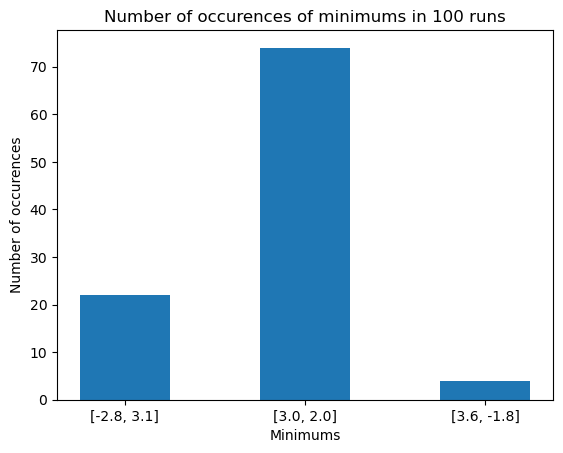

Average value: 0.10426887047747434
Standard deviation value: 0.17971066129951754
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.1 numberOfGenerations: 30 
Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]


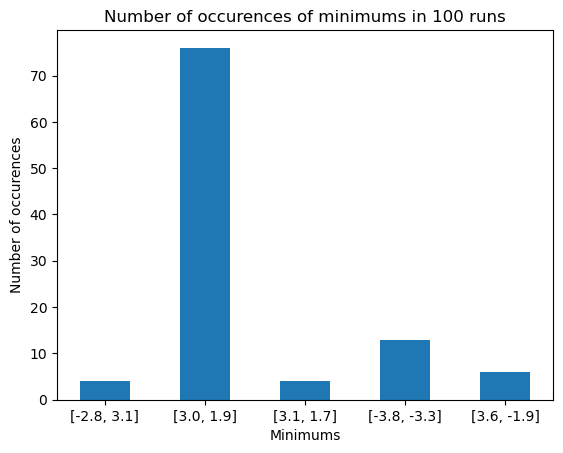

Average value: 0.17193778941236562
Standard deviation value: 0.24692318032090058
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.5 numberOfGenerations: 30 
Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]


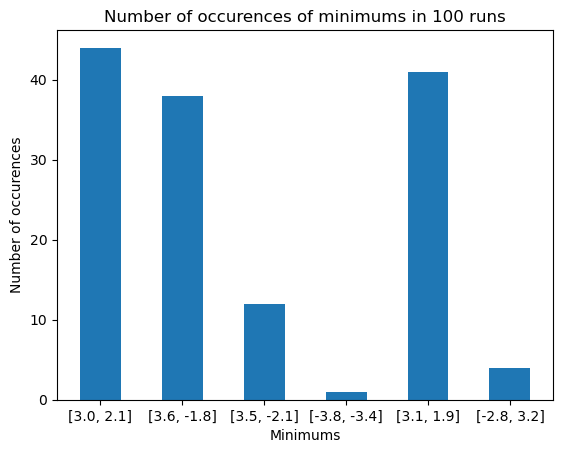

Average value: 0.44653877577199574
Standard deviation value: 0.26180236601158985
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.3 numberOfGenerations: 30 
Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]


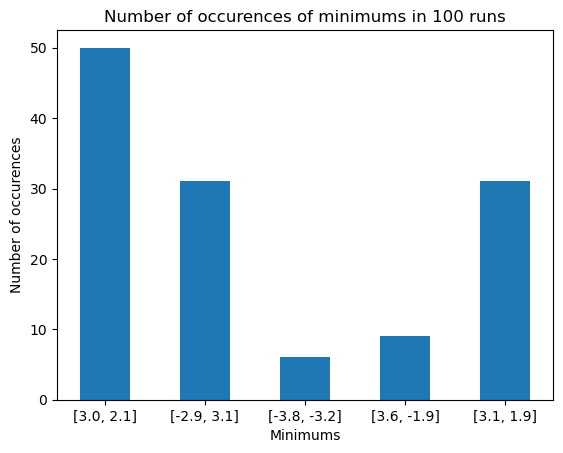

Average value: 0.2545279464878202
Standard deviation value: 0.16444769587934352
##############################################################################################################################################################################


In [62]:
D=[-5,5]
size=80
numberOfGenerations=30

crossingProbability=0.8
sigma=0.1
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
printStatistics(numberOfGenerations,size,crossingProbability,sigma,D)

print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.1
numberOfGenerations=30

print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
printStatistics(numberOfGenerations,size,crossingProbability,sigma,D)

print("##############################################################################################################################################################################")

D=[-5,5]
size=80
crossingProbability=0.87
sigma=0.1
numberOfGenerations=30

print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
printStatistics(numberOfGenerations,size,crossingProbability,sigma,D)

print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.3
numberOfGenerations=30

print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
printStatistics(numberOfGenerations,size,crossingProbability,sigma,D)


print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.05
numberOfGenerations=30

print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
printStatistics(numberOfGenerations,size,crossingProbability,sigma,D)

print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.8
sigma=0.1
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]')
printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation)

print("##############################################################################################################################################################################")

D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.1
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]')
printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation)

print("##############################################################################################################################################################################")

D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.5
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]')
printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation)

print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.3
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]')
printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation)

print("##############################################################################################################################################################################")

# Zestawienie Wyników: 
| sposób generacji populacji początkowej | sigma | r. populacji | p. krzyżowania | l. generacji | Średnia Wartość | Odchylenie standardowe |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| Rozkład jednorodny | 0.1 | 80 | 0.8 | 30 | 0.08509109761986636 | 0.1567053465787504 | 
| Rozkład jednorodny | 0.1 | 80 | 0.95 | 30 | 0.08208201465505045 | 0.10301217591767436 |
| Rozkład jednorodny | 0.1 | 80 | 0.87 | 30 | 0.07870743094501695 | 0.11587278044016451 |
| Rozkład jednorodny | 0.3 | 80 | 0.95 | 30 | 0.18492310068048343 | 0.11572296675587528 |
| Rozkład jednorodny | 0.05 | 80 | 0.95 | 30 | 0.13474200675071812 | 0.22129455603274553 |
| Rozkład normalny dla x1,y1 dla innych jednorodny | 0.1 | 80 | 0.8 | 30 | 0.10426887047747434 | 0.17971066129951754 |
| Rozkład normalny dla x1,y1 dla innych jednorodny | 0.1 | 80 | 0.95 | 30 | 0.17193778941236562 | 0.24692318032090058 |
| Rozkład normalny dla x1,y1 dla innych jednorodny | 0.5 | 80 | 0.95 | 30 | 0.44653877577199574 | 0.26180236601158985 |
| Rozkład normalny dla x1,y1 dla innych jednorodny | 0.3 | 80 | 0.95 | 30 | 0.2545279464878202 | 0.16444769587934352 |
